In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score
import pickle
import os
import seaborn as sns

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
save_path = os.path.join(BASE_DIR, "web", "predictor", "titanic_model.pkl")

In [ ]:
train_data = pd.read_csv('../data/processed/train_features.csv')
X = train_data[["Sex","Fare","FamilySize",
                "Pclass_2","Pclass_3",
                "AgeBin_Teen","AgeBin_Adult", "AgeBin_Middle Aged","AgeBin_Senior",
                "Embarked_C","Embarked_Q",
                "Title_Miss","Title_Mrs","Title_Mr","Title_Rare",
                ]].copy()
y = train_data['Survived']

In [4]:
X.head()

,Sex,Pclass,Fare,FamilySize,AgeBin_Child,AgeBin_Teen,AgeBin_Adult,AgeBin_Middle Aged,AgeBin_Senior,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mrs,Title_Mr,Title_Rare
0,0,3,7.2500,2,0,0,1,0,0,0,0,1,0,0,0,1,0
1,1,1,71.2833,2,0,0,1,0,0,1,0,0,0,0,1,0,0
2,1,3,7.9250,1,0,0,1,0,0,0,0,1,0,1,0,0,0
3,1,1,53.1000,2,0,0,1,0,0,0,0,1,0,0,1,0,0
4,0,3,8.0500,1,0,0,1,0,0,0,0,1,0,0,0,1,0


In [5]:
# test_train split is tested on 0.1,0.2,0.3, and 0.1 gives the highest test accuracy 
# the final model to export to Django is the model trained with all features combined
#
accuracy = []
number_of_features = X.shape[1]
for i in range(number_of_features):
    data = X.iloc[:,[i]]
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] 
    accuracy.append(accuracy_score(y_test, y_pred)) 
    #print("Accuracy:", accuracy_score(y_test, y_pred))
    #print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [6]:
best_singel_feature_idx = accuracy.index(max(accuracy))

In [7]:
# To check if the training dataset is 'balanced' or not
y.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [8]:
# "Not survived" person is around 61.8%(549 persons) and "Survived" person is around 38%.
# The training dataset is slightly biased towards to "Not survied", add class_weight = 'balanced' to train the model

# Split the dataset to Train/Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter= 500,class_weight='balanced')
model.fit(X_train, y_train)
# Predict on Test data
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 

# Since our dataset is "imbalanced", f1 score is more proper than accuracy.
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, pos_label=1)
print("F1 score for survivors:", f1)

# Cross-validation ONLY on training data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
print("CV Mean F1:", f1_scores.mean())


accuracy.append(accuracy_score(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       105
           1       0.74      0.82      0.78        74

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.81       179
weighted avg       0.82      0.81      0.81       179

F1 score for survivors: 0.782051282051282
CV Mean F1: 0.7581469781469782


In [9]:
#with open(save_path, "wb") as f:
#     pickle.dump(model, f)

# print("Model saved to:", save_path)

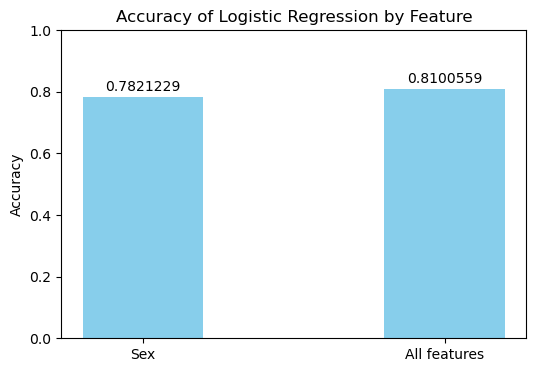

In [10]:
features = [X.columns[best_singel_feature_idx], "All features"] 
accuracies = [accuracy[best_singel_feature_idx],accuracy[-1]]
# Plot accuracy comparation for the best singel feature and all features
plt.figure(figsize=(6,4))
for i in range(2):
    plt.bar(features[i], accuracies[i], color='skyblue',width=0.4)
    plt.text(i, accuracies[i]+ 0.02, f"{accuracies[i]:.7f}", ha='center')  

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy of Logistic Regression by Feature')
plt.show()

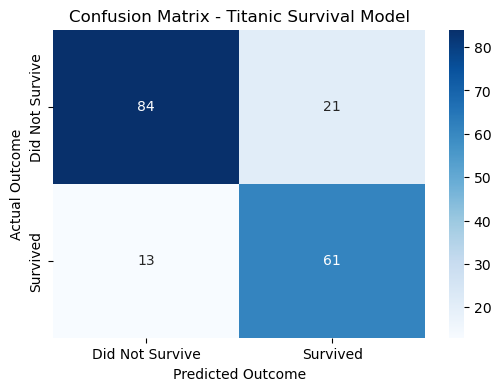

In [ ]:
# confusion matrix
labels = ["Did Not Survive", "Survived"]

cm = confusion_matrix(y_test, y_pred)

# visualization
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion Matrix - Logistic Regression Model")
plt.xlabel("Predicted Outcome")
plt.ylabel("Actual Outcome")
plt.show()